Take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for a classification task.

Sources:  
https://huggingface.co/neuralmind/bert-large-portuguese-cased  
https://huggingface.co/transformers/v3.0.2/model_doc/auto.html  
https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=GEgLpFVlo1Z-  

Also see:  
https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/  
https://arxiv.org/abs/1905.05583  
https://github.com/alan-vieira/analise_sent_twitter_bert/blob/main/an_sent_BERTimbau.ipynb  
https://github.com/thomas-ferraz/FakeNews-BERTimbau/blob/main/Modelo_BERTimbau.ipynb  
https://github.com/DiogoPedro/Bertimbau/blob/main/Aprendizagem%20profunda%20-%20Projeto/C%C3%B3digo/C%C3%B3digo_do_Bertimbau.ipynb  


# import libraries

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader,RandomSampler,SequentialSampler,random_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, BatchNormalization, Dropout,Bidirectional
#from keras_preprocessing.sequence import pad_sequences
from keras.optimizers import SGD, Adam
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import confusion_matrix
import random
import seaborn as sns


In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

#model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/MS DATA SCIENCE /TESE /data_processed.csv')
data.head()

,Unnamed: 0,date,title,reason,description,zone,brand_replies,dates_brand_replies,user_replies,dates_user_replies,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,narrative_embeddings_title
0,0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,Mau Serviço Prestado,Bom dia venho por este meio apresentar uma rec...,Lisboa,"Estimado(a) Cliente, Nuno,\r\n\r\nInformamos q...","2021-10-11 12:35:57, 2021-10-13 13:22:26, 2021...",A situação fica resolvida apenas tendo que abr...,"2021-10-22 10:50:49, 2021-10-22 12:13:16, 2021...",bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,ctt - encomenda entregue danificada e com etiq...
1,1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,Condições de entrega,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,"Estimado(a) Cliente, Lilia Alexandra Pimentel,...","2021-08-31 23:20:16, 2021-09-02 13:31:01,",NaN,NaN,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! - Venho por este meio reclamar qu...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,ctt - carta com certificado rasgado ! - boa no...
2,2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,Atraso de entrega,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,"Estimado(a) Cliente, Ana Cristina Costa Soares...","2021-02-01 19:08:36, 2021-02-02 12:08:33, 2021...","Olá boa tarde,\r\nAté agora continua tudo igua...","2021-02-18 16:26:12, 2021-02-18 16:27:35, 2021...",bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,ctt - encomenda registada que nunca chegou ao ...
3,3,2018-04-19 09:04:34,CTT - Correio Verde,Atraso de entrega,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,Exmo. Senhor\n\nBruno Garcia \n\nGostaríamos d...,"2018-04-20 10:16:13,",Situação resolvida! Obrigado.,"2018-04-20 10:28:48,",bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...","ctt - correio verde bom dia,\n\npretendia escl..."
4,4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",Atraso de entrega,venho por este meio solicitar a vossa ajuda pa...,Porto,Exmo (a). Senhor (a) \r\n\r\nGostaríamos de ag...,"2019-07-05 10:30:04, 2020-07-24 13:24:17,",NaN,NaN,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...","ctt - aviso de recepção da carta registada , p..."


In [ ]:
len(data)

22430

In [ ]:
# convert reason to numbers
reason_dict ={'Mau Serviço Prestado': 0, 'Condições de entrega': 1, 'Atraso de entrega': 2, 
               'Enganos': 3}

data['reason'].replace(reason_dict, inplace=True)

In [ ]:
data['reason'].unique()

array([0, 1, 2, 3])

# Multiclass classification

## sentence length

In [ ]:
# tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            data.narrative_bert_title.values.tolist(), 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
token_sentence_length=[]
# collect tokenized sentence length 
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]
    
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  10585
min:  32


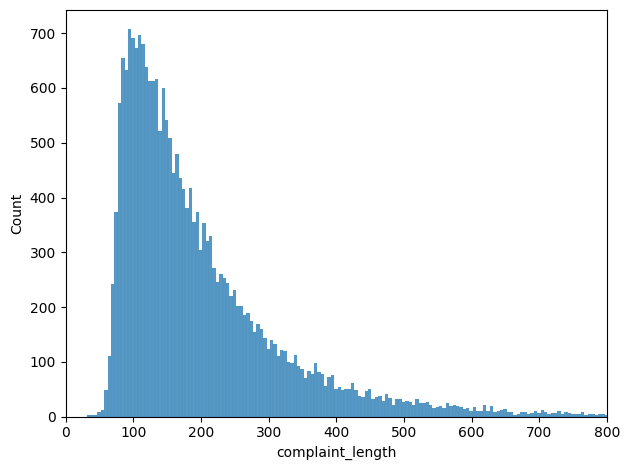

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
sum(data['complaint_length']>800)

241

## tokenize sentences and input formatting

In [ ]:
# identify features and target
sentences = data.narrative_bert_title.values
labels = data.reason.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # Add empty tokens if len(text)<MAX_LEN
                        padding = 'max_length',
                        # Truncate all sentences to max length
                        truncation=True,
                        max_length = 200,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  ctt - encomenda entregue danificada e com etiquetas de envios e registos diferentes  Bom dia venho por este meio apresentar uma reclamação aos CTT. Enviei uma encomenda cujo conteúdo era uma figura de resina artesanal. O envio foi destinado a um amigo de Israel. O envio foi feito no dia 2021-09-09 no posto de ctt da Aboboda. Código: RT106043625PT O envio estava muito bem ambalado e protegido, tinha uma segunda caixa onde estava a figura protegita com muito papel bolha e esponjas. Infelizmente o meu amigo recebeu uma caixa que chegou quase destruida, figura partida, e chegou passado um mês. Mas aqui vão os problemas todos: - Levou muito tempo a chegar - A caixa chegou destruida - A caixa tinha sido aberta e tinha as etiquetas mudadas - A caixa tinha um segundo nome de remetente português e um novo remetente em Israel. - Pior: A figura chegou danificada e partida, sem concerto. Nas fotos envidas tinha uma etiqueta com novo tracking number alterado e com remetente novo de Braga

## train val test split 80-10-10

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size =int((len(dataset) - train_size)*0.5)
test_size= int(len(dataset) - train_size - val_size)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} total samples'.format(len(dataset)))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

22,430 total samples
17,944 training samples
2,243 validation samples
2,243 test samples


## load training, validation and test data into Tensor DataLoader

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Test 
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
    )

## set up model 

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
# Here we define a model that includes a pre-trained base 
# (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. 
# One should fine-tune this head, together with the pre-trained base on a labeled dataset.
# This is also printed by the warning.
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (29794, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## training loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    valid_loss_min = np.Inf 

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader.  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # saving the model if validation loss has decreased
    if avg_val_loss < valid_loss_min:
      print('Saving model')
      torch.save(model.state_dict(), 'saved_weights_bertimbau.pt')
      valid_loss_min = avg_val_loss

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    50  of  1,122.    Elapsed: 0:00:26.
  Batch   100  of  1,122.    Elapsed: 0:00:52.
  Batch   150  of  1,122.    Elapsed: 0:01:19.
  Batch   200  of  1,122.    Elapsed: 0:01:46.
  Batch   250  of  1,122.    Elapsed: 0:02:14.
  Batch   300  of  1,122.    Elapsed: 0:02:42.
  Batch   350  of  1,122.    Elapsed: 0:03:10.
  Batch   400  of  1,122.    Elapsed: 0:03:39.
  Batch   450  of  1,122.    Elapsed: 0:04:08.
  Batch   500  of  1,122.    Elapsed: 0:04:37.
  Batch   550  of  1,122.    Elapsed: 0:05:06.
  Batch   600  of  1,122.    Elapsed: 0:05:35.
  Batch   650  of  1,122.    Elapsed: 0:06:05.
  Batch   700  of  1,122.    Elapsed: 0:06:34.
  Batch   750  of  1,122.    Elapsed: 0:07:04.
  Batch   800  of  1,122.    Elapsed: 0:07:33.
  Batch   850  of  1,122.    Elapsed: 0:08:03.
  Batch   900  of  1,122.    Elapsed: 0:08:32.
  Batch   950  of  1,122.    Elapsed: 0:09:02.
  Batch 1,000  of  1,122.    Elapsed: 0:09:32.
  Batch 1,050  of

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option("display.precision", 2)
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.87,0.83,0.66,0:10:44,0:00:30
2,0.73,0.83,0.67,0:11:07,0:00:30
3,0.59,0.94,0.65,0:11:07,0:00:30
4,0.47,1.04,0.63,0:11:08,0:00:30


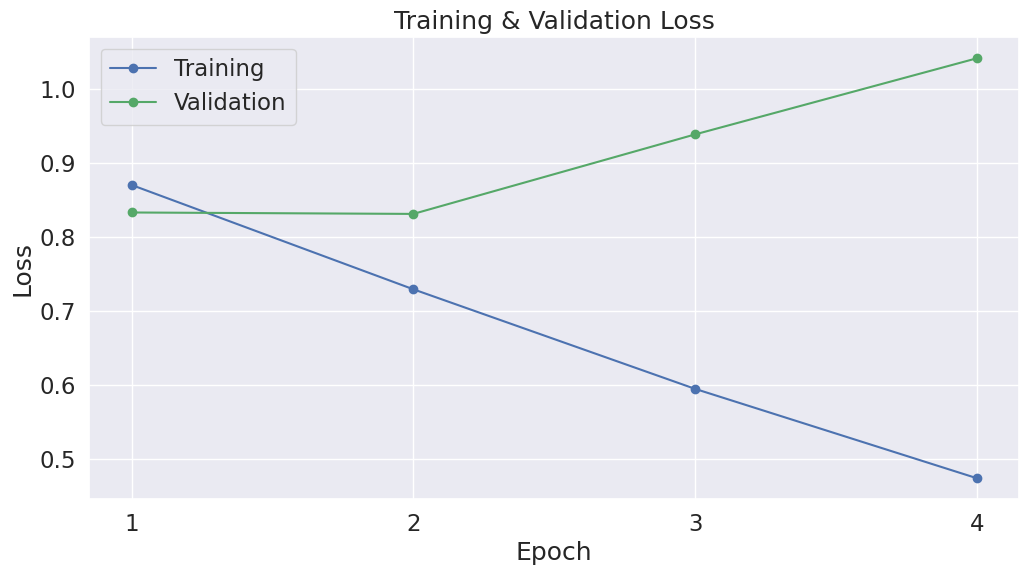

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## evaluation on test set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 22,430 test sentences...
    DONE.


In [ ]:
predictions

[array([[ 2.86149883e+00, -1.49893045e+00,  1.91450584e+00,
         -2.86643529e+00],
        [ 2.26337647e+00, -1.22720742e+00,  1.13514030e+00,
         -1.64446139e+00],
        [ 1.56247818e+00, -1.73985732e+00,  3.34979010e+00,
         -2.98113704e+00],
        [ 2.32516509e-02, -1.05776393e+00,  4.29629612e+00,
         -3.21836686e+00],
        [ 2.04747581e+00, -6.51409090e-01, -1.45680392e+00,
          1.28133991e-03],
        [ 2.99069691e+00, -1.72190523e+00,  6.43787205e-01,
         -2.02977252e+00],
        [ 8.50173473e-01,  5.60281456e-01, -3.07283330e+00,
          1.53208911e+00],
        [ 2.10123205e+00,  8.75159204e-01, -2.37743473e+00,
         -5.86382031e-01],
        [ 5.38156092e-01, -1.25803626e+00,  4.07714796e+00,
         -3.24689841e+00],
        [ 1.25046945e+00,  2.86915839e-01, -2.90843630e+00,
          1.46420479e+00],
        [ 3.48727918e+00, -7.18816876e-01, -2.12592836e-02,
         -2.65841269e+00],
        [ 1.89055991e+00,  1.83766150e+00, 

In [ ]:
true_labels

[array([0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 2]),
 array([0, 0, 2, 1, 2, 2, 0, 0, 0, 3, 2, 1, 2, 2, 0, 2]),
 array([2, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 2, 3, 0]),
 array([2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 0]),
 array([2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 2, 3]),
 array([2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 0, 3]),
 array([2, 1, 0, 3, 0, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2]),
 array([2, 2, 0, 0, 2, 0, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2]),
 array([0, 2, 3, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2]),
 array([0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2]),
 array([2, 0, 2, 0, 0, 0, 1, 1, 2, 3, 2, 2, 0, 0, 0, 2]),
 array([2, 0, 3, 0, 2, 2, 0, 0, 2, 3, 3, 2, 0, 2, 0, 2]),
 array([2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 1, 0]),
 array([0, 0, 1, 3, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0]),
 array([2, 2, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 0, 2, 0, 0]),
 array([2, 1, 2, 0, 1, 2, 2, 3, 2, 2, 1, 2, 2, 0, 2, 0]),
 array([0, 1, 0, 0, 0, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2]),
 array([2, 2, 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(flat_true_labels, flat_predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.56      0.66      0.61       773
           1       0.33      0.15      0.21       221
           2       0.79      0.78      0.79      1100
           3       0.36      0.35      0.35       149

    accuracy                           0.65      2243
   macro avg       0.51      0.49      0.49      2243
weighted avg       0.64      0.65      0.64      2243



In [ ]:
cf=confusion_matrix(flat_true_labels, flat_predictions, labels=[0,1,2,3])
print(cf)

[[511  38 173  51]
 [112  34  43  32]
 [207  23 859  11]
 [ 77   9  11  52]]


# binary classification

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MS DATA SCIENCE /TESE /data_processed.csv')

In [ ]:
#convert reason to numbers
reason_dict ={'Mau Serviço Prestado': 0, 'Condições de entrega': 0, 'Atraso de entrega': 1, 
               'Enganos': 0}

data['reason'].replace(reason_dict, inplace=True)

In [ ]:
data.head()

,Unnamed: 0,date,title,reason,description,zone,brand_replies,dates_brand_replies,user_replies,dates_user_replies,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,narrative_embeddings_title
0,0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,"Estimado(a) Cliente, Nuno,\r\n\r\nInformamos q...","2021-10-11 12:35:57, 2021-10-13 13:22:26, 2021...",A situação fica resolvida apenas tendo que abr...,"2021-10-22 10:50:49, 2021-10-22 12:13:16, 2021...",bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,ctt - encomenda entregue danificada e com etiq...
1,1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,0,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,"Estimado(a) Cliente, Lilia Alexandra Pimentel,...","2021-08-31 23:20:16, 2021-09-02 13:31:01,",NaN,NaN,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! - Venho por este meio reclamar qu...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,ctt - carta com certificado rasgado ! - boa no...
2,2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,1,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,"Estimado(a) Cliente, Ana Cristina Costa Soares...","2021-02-01 19:08:36, 2021-02-02 12:08:33, 2021...","Olá boa tarde,\r\nAté agora continua tudo igua...","2021-02-18 16:26:12, 2021-02-18 16:27:35, 2021...",bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,ctt - encomenda registada que nunca chegou ao ...
3,3,2018-04-19 09:04:34,CTT - Correio Verde,1,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,Exmo. Senhor\n\nBruno Garcia \n\nGostaríamos d...,"2018-04-20 10:16:13,",Situação resolvida! Obrigado.,"2018-04-20 10:28:48,",bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...","ctt - correio verde bom dia,\n\npretendia escl..."
4,4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",1,venho por este meio solicitar a vossa ajuda pa...,Porto,Exmo (a). Senhor (a) \r\n\r\nGostaríamos de ag...,"2019-07-05 10:30:04, 2020-07-24 13:24:17,",NaN,NaN,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...","ctt - aviso de recepção da carta registada , p..."


## sentence length

In [ ]:
# tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            data.narrative_bert_title.values.tolist(), 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
token_sentence_length=[]
# collect tokenized sentence length 
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]
    
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  10585
min:  32


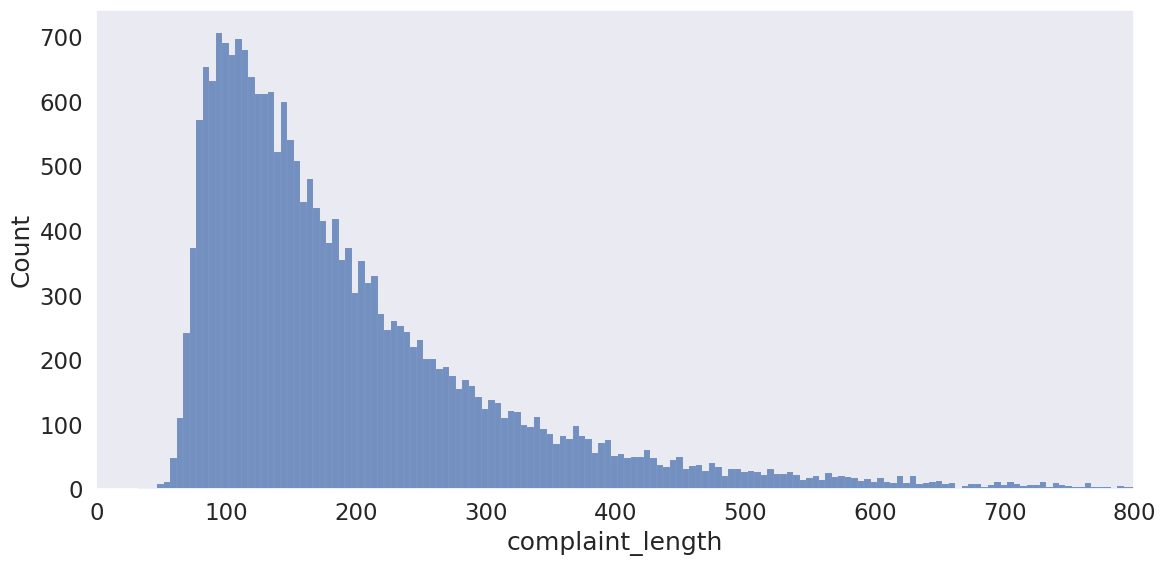

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
sum(data['complaint_length']>800)

241

## tokenize sentences and input formatting

In [ ]:
# identify features and target
sentences = data.narrative_bert_title.values
labels = data.reason.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # Add empty tokens if len(text)<MAX_LEN
                        padding = 'max_length',
                        # Truncate all sentences to max length
                        truncation=True,
                        max_length = 200,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  ctt - encomenda entregue danificada e com etiquetas de envios e registos diferentes  Bom dia venho por este meio apresentar uma reclamação aos CTT. Enviei uma encomenda cujo conteúdo era uma figura de resina artesanal. O envio foi destinado a um amigo de Israel. O envio foi feito no dia 2021-09-09 no posto de ctt da Aboboda. Código: RT106043625PT O envio estava muito bem ambalado e protegido, tinha uma segunda caixa onde estava a figura protegita com muito papel bolha e esponjas. Infelizmente o meu amigo recebeu uma caixa que chegou quase destruida, figura partida, e chegou passado um mês. Mas aqui vão os problemas todos: - Levou muito tempo a chegar - A caixa chegou destruida - A caixa tinha sido aberta e tinha as etiquetas mudadas - A caixa tinha um segundo nome de remetente português e um novo remetente em Israel. - Pior: A figura chegou danificada e partida, sem concerto. Nas fotos envidas tinha uma etiqueta com novo tracking number alterado e com remetente novo de Braga

## train val test split

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size =int((len(dataset) - train_size)*0.5)
test_size= int(len(dataset) - train_size - val_size)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} total samples'.format(len(dataset)))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

22,430 total samples
17,944 training samples
2,243 validation samples
2,243 test samples


## load training, validation and test data into Tensor DataLoader

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Test 
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
    )

## set up model 

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
# Here we define a model that includes a pre-trained base 
# (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. 
# One should fine-tune this head, together with the pre-trained base on a labeled dataset.
# This is also printed by the warning.
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## training loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    valid_loss_min = np.Inf 

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader.  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # saving the model if validation loss has decreased
    if avg_val_loss < valid_loss_min:
      print('Saving model')
      torch.save(model.state_dict(), 'saved_weights_bertimbau.pt')
      valid_loss_min = avg_val_loss

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    50  of  1,122.    Elapsed: 0:00:26.
  Batch   100  of  1,122.    Elapsed: 0:00:54.
  Batch   150  of  1,122.    Elapsed: 0:01:22.
  Batch   200  of  1,122.    Elapsed: 0:01:50.
  Batch   250  of  1,122.    Elapsed: 0:02:19.
  Batch   300  of  1,122.    Elapsed: 0:02:48.
  Batch   350  of  1,122.    Elapsed: 0:03:17.
  Batch   400  of  1,122.    Elapsed: 0:03:45.
  Batch   450  of  1,122.    Elapsed: 0:04:14.
  Batch   500  of  1,122.    Elapsed: 0:04:44.
  Batch   550  of  1,122.    Elapsed: 0:05:13.
  Batch   600  of  1,122.    Elapsed: 0:05:42.
  Batch   650  of  1,122.    Elapsed: 0:06:12.
  Batch   700  of  1,122.    Elapsed: 0:06:41.
  Batch   750  of  1,122.    Elapsed: 0:07:11.
  Batch   800  of  1,122.    Elapsed: 0:07:40.
  Batch   850  of  1,122.    Elapsed: 0:08:10.
  Batch   900  of  1,122.    Elapsed: 0:08:40.
  Batch   950  of  1,122.    Elapsed: 0:09:10.
  Batch 1,000  of  1,122.    Elapsed: 0:09:39.
  Batch 1,050  of

In [60]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option("display.precision", 2)
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.48,0.79,0:10:52,0:00:30
2,0.39,0.48,0.81,0:11:09,0:00:31
3,0.30,0.54,0.79,0:11:06,0:00:30
4,0.21,0.69,0.78,0:11:09,0:00:30


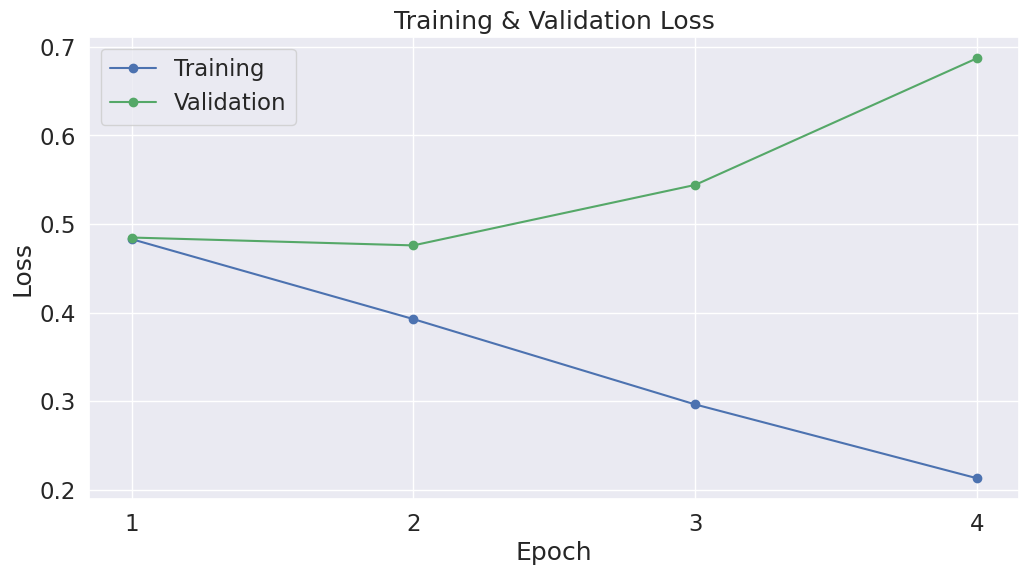

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [62]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## evaluation on test set

In [63]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 22,430 test sentences...
    DONE.


In [64]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)



In [65]:
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(flat_true_labels, flat_predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1183
           1       0.76      0.79      0.78      1060

    accuracy                           0.78      2243
   macro avg       0.78      0.78      0.78      2243
weighted avg       0.78      0.78      0.78      2243



In [66]:
cf=confusion_matrix(flat_true_labels, flat_predictions, labels=[0,1])
print(cf)

[[922 261]
 [224 836]]
